## Timeseries analysis of StatsNZ trade data

In this notebook, I will examine StatsNZ trade data between January 2014 and September 2022. The trade data includes values of NZ Exports and Imports for goods and services per country and product codes. 

The table is available from the Stats NZ trade website: 
<a href="https://statisticsnz.shinyapps.io/trade_dashboard/">Stats NZ Trade Dashboard</a>


#### Importing data 

In [1]:
#importing python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#setting plot style
plt.style.use('seaborn')

#setting plot size
plt.rcParams['figure.figsize'] = [12,6]

In [2]:
#reading data into dataframe df

file = '../data/Tradedata.csv'

quarter_date_parser = lambda x: datetime.strptime(x, "%Y%m")

df = pd.read_csv(file, parse_dates=['Period'], date_parser=quarter_date_parser, index_col='Period') 


In [3]:
df.head(5)

,Country Code,Country,Account,Category,Code,Flag,Total Value (NZD),Description
Period,,,,,,,,
2014-06-01,AF,Afghanistan,Imports,Goods,00,F,131905.0,Total
2014-06-01,AF,Afghanistan,Imports,Goods,08,F,107337.0,Fruits and nuts
2014-06-01,AF,Afghanistan,Imports,Goods,12,F,316.0,Oil seeds
2014-06-01,AF,Afghanistan,Imports,Goods,30,F,21786.0,Pharmaceuticals
2014-06-01,AF,Afghanistan,Imports,Goods,42,F,156.0,Leather products


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413815 entries, 2014-06-01 to 2022-09-01
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Country Code       413179 non-null  object 
 1   Country            413751 non-null  object 
 2   Account            413815 non-null  object 
 3   Category           413815 non-null  object 
 4   Code               413815 non-null  object 
 5   Flag               413815 non-null  object 
 6   Total Value (NZD)  413815 non-null  float64
 7   Description        413815 non-null  object 
dtypes: float64(1), object(7)
memory usage: 28.4+ MB


The trade table contains 413815 rows and 8 columns. The 'Country' and 'Country Code' columns have 64 and 636 missing values retrospectively. 

In [5]:
print('Number of missing values in Country column:', df['Country'].isnull().sum())
print('Number of missing values in Country Code column:', df['Country Code'].isnull().sum())

#print(df[df['Country'].isnull()])
#print(df[df['Country Code'].isnull()])

Number of missing values in Country column: 64
Number of missing values in Country Code column: 636


The trade table contains 413815 rows and 8 columns.  The columns, 'Country' and 'Country Code' have some missing values.  

#### Dataframes for goods

In [6]:
#creating data frames for exported and imported goods

goods_exports= df[(df["Account"]=='Exports') & (df["Category"]=='Goods') ]
goods_imports= df[(df["Account"]=='Imports') & (df["Category"]=='Goods') ]

#size of dataframes
print('goods_exports:', goods_exports.shape, 'goods_imports:', goods_imports.shape)

goods_exports: (164196, 8) goods_imports: (185076, 8)


Values of exports and imports are aggregated per quarter. The quarters are marked with the numbers: '03' - the first quarter, '06' - the second quarter, '09' - the third, and '12' - the fourth quarter

In [7]:
print('Time Interval: between ', goods_exports.index.min(), 'quarter and ', goods_exports.index.max(), 'quarter')

Time Interval: between  2014-06-01 00:00:00 quarter and  2022-09-01 00:00:00 quarter


Exported and imported products are labeled as two digits codes, where the code '00' represents the total values of all exported/imported products per country 

In [8]:
#number of unique codes for exported products, excluding '00' codes

print('Number of unique codes for exported products:', goods_exports[goods_exports['Code']!='00']['Code'].nunique())

print('Number of unique codes for imported products:', goods_imports[goods_imports['Code']!='00']['Code'].nunique())

Number of unique codes for exported products: 97
Number of unique codes for imported products: 97


In [9]:
#number of countries per quarter

countries_perquarter_exp = goods_exports.groupby('Period')['Country'].nunique()
countries_perquarter_imp = goods_imports.groupby('Period')['Country'].nunique()

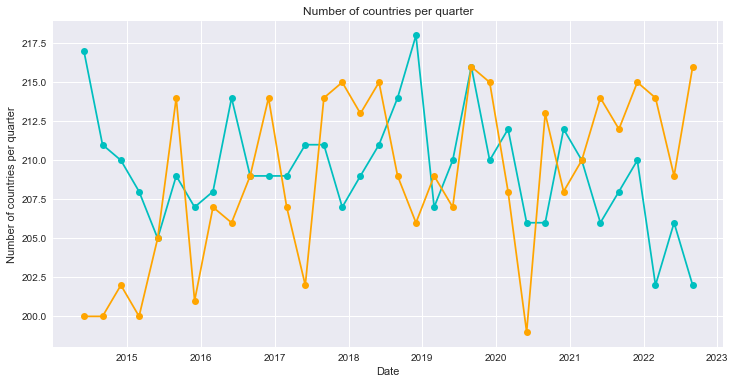

In [10]:
fig,ax = plt.subplots()
line1=ax.plot(countries_perquarter_exp.index, countries_perquarter_exp.values, color = 'c', marker='o',label="Exports")
line2=ax.plot(countries_perquarter_imp.index, countries_perquarter_imp.values, color = 'orange', marker='o', label="Imports")

ax.set_xlabel('Date')
ax.set_title('Number of countries per quarter')
ax.set_ylabel('Number of countries per quarter')
plt.show()

In [11]:
#total exports per country

goods_exports_total= df[(df["Account"]=='Exports') & (df["Category"]=='Goods')  & (df["Description"]=='Total')]
print(goods_exports_total.head(5))

           Country Code      Country  Account Category Code Flag  \
Period                                                             
2014-06-01           AF  Afghanistan  Exports    Goods   00    F   
2014-06-01           AL      Albania  Exports    Goods   00    F   
2014-06-01           DZ      Algeria  Exports    Goods   00    F   
2014-06-01           AO       Angola  Exports    Goods   00    F   
2014-06-01           AQ   Antarctica  Exports    Goods   00    F   

            Total Value (NZD) Description  
Period                                     
2014-06-01            20620.0       Total  
2014-06-01           156520.0       Total  
2014-06-01        183286021.0       Total  
2014-06-01         12731987.0       Total  
2014-06-01            25229.0       Total  


#### Dataframes for services

In [12]:
#creating data frames for exported and imported services

services_exports= df[(df["Account"]=='Exports') & (df["Category"]=='Services') ]
services_imports= df[(df["Account"]=='Imports') & (df["Category"]=='Services') ]

#size of dataframes
print('services_exports:', services_exports.shape, 'services_imports:', services_imports.shape)

services_exports: (35756, 8) services_imports: (28787, 8)


In [13]:
print('Time Interval: between' , services_exports.index.min(), 'quarter and ', services_exports.index.max(), 'quarter')

Time Interval: between 2014-06-01 00:00:00 quarter and  2022-09-01 00:00:00 quarter


Exported and imported services are labeled with two and four digits A codes. 

In [14]:
#number of countries per services code

services_exp = services_exports.groupby('Code')['Country'].nunique()
services_imp = services_imports.groupby('Code')['Country'].nunique()
print(pd.merge(services_exp, services_imp, left_on=services_exp.index, right_on=services_imp.index, how='left'))

    key_0  Country_x  Country_y
0     A12        242        240
1   A1202         60         67
2   A1203         61         64
3   A1204        241        234
4   A1205         61         65
5   A1206         54         49
6   A1207        150         74
7   A1208        163        123
8   A1209        178        174
9   A1210        212        210
10  A1211        164        121
11  A1212        234         49


In [15]:
#number of countries per quarter 
countries_perquarter = services_exports.groupby('Period')['Country'].nunique()